## Import the Model

In [1]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Import Libraries and Helper Functions

In [3]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [4]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [5]:
def deprocess(x):
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

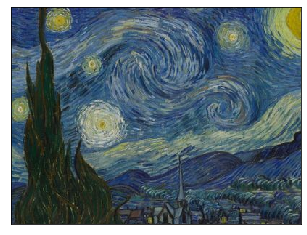

In [6]:
display_image(load_and_process_image('starry-night.jpg'))

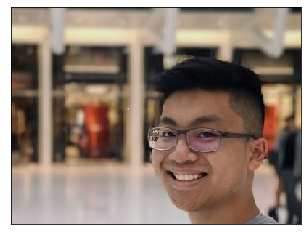

In [7]:
display_image(load_and_process_image('stanley.jpg'))

## Content and Style Models

In [8]:
content_layer = 'block5_conv2'

style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)
style_models = [Model(inputs = model.input, outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [9]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

## Gram Matrix

In [10]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a = True)
    return G / tf.cast(n, tf.float32)

## Style Cost

In [11]:
lam = 1. / len(style_models)
def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    return J_style

## Training Loop

In [12]:
import time

In [13]:
generated_images = []

def training_loop(content_path, style_path, iterations = 40, alpha = 10., beta = 20.):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    
    generated = tf.Variable(content, dtype = tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 7.)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content + beta * J_style
            
        grads = tape.gradient(J_total, generated)
        optimizer.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time.time() - start_time))
        generated_images.append(generated.numpy())
        
    return best_image

In [14]:
best_image = training_loop('stanley.jpg', 'starry-night.jpg')

Cost at 0: 1425078016.0. Time elapsed: 22.30409860610962
Cost at 1: 694060736.0. Time elapsed: 43.47199988365173
Cost at 2: 532067424.0. Time elapsed: 69.74296760559082
Cost at 3: 509217312.0. Time elapsed: 106.50175642967224
Cost at 4: 372100224.0. Time elapsed: 141.6461465358734
Cost at 5: 295773248.0. Time elapsed: 168.36726903915405
Cost at 6: 249727968.0. Time elapsed: 195.3222827911377
Cost at 7: 214000016.0. Time elapsed: 221.36694145202637
Cost at 8: 184864032.0. Time elapsed: 245.44006776809692
Cost at 9: 159743104.0. Time elapsed: 270.15295362472534
Cost at 10: 140059072.0. Time elapsed: 291.6724007129669
Cost at 11: 126078104.0. Time elapsed: 317.4095666408539
Cost at 12: 114329104.0. Time elapsed: 340.189665555954
Cost at 13: 102579064.0. Time elapsed: 361.3070101737976
Cost at 14: 92207704.0. Time elapsed: 379.828471660614
Cost at 15: 83979400.0. Time elapsed: 398.2432208061218
Cost at 16: 76834696.0. Time elapsed: 416.1084394454956
Cost at 17: 70171680.0. Time elapsed: 43

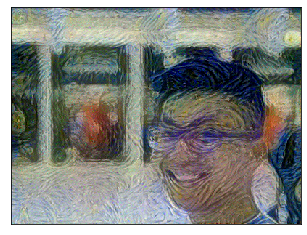

In [15]:
display_image(best_image)

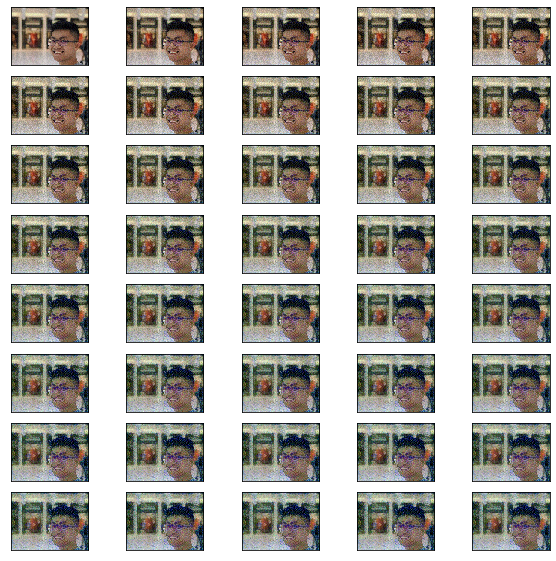

In [16]:
plt.figure(figsize = (10, 10))

for i in range(40):
    plt.subplot(8, 5, i+1)
    display_image(generated_images[i])
    
plt.show()